# Extração de cotações do dólar (versão pandas)

Este notebook replica o script `Extracao_de_dados_para_uma_tabela.py` usando pandas.
Execute as células abaixo na ordem para obter as cotações, gravar no banco SQLite (`cotacoes.db`) ou salvar um CSV de fallback.

In [ ]:
import requests
import pandas as pd
from sqlalchemy import create_engine
import subprocess, sys



# Parâmetros (edite conforme necessário)
data_inicial = "01-01-2020"  # formato MM-DD-YYYY
data_final = "09-30-2025"    # formato MM-DD-YYYY

# Monta a URL da API do BACEN
url = f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='{data_inicial}'&@dataFinalCotacao='{data_final}'&$format=json&$select=cotacaoVenda,dataHoraCotacao"

print('URL montada:', url)

In [ ]:
# Requisição à API e transformação em DataFrame pandas
r = requests.get(url)
r.raise_for_status()

dados = r.json()
# API retorna em {'value': [...]} — protegemos com .get
dados_2 = dados.get('value', [])

# Cria DataFrame e converte a coluna de data
df_cotacoes = pd.DataFrame(dados_2)
if 'dataHoraCotacao' in df_cotacoes.columns:
    df_cotacoes['dataHoraCotacao'] = pd.to_datetime(df_cotacoes['dataHoraCotacao'])

# Exibe um resumo rápido
print(f"Linhas obtidas: {len(df_cotacoes)}")
df_cotacoes.head()

In [ ]:
# Gravação no SQLite (ou CSV de fallback)
engine = create_engine('sqlite:///cotacoes.db')
nomeTabela = 'cotacoes_dolar'

def _check_db_connection(engine):
    try:
        with engine.connect() as conn:
            conn.execute('SELECT 1')
        return True, None
    except Exception as e:
        return False, e

available, conn_err = _check_db_connection(engine)
if available:
    try:
        df_cotacoes.to_sql(name=nomeTabela, con=engine, if_exists='replace', index=False)
        print(f"Dados inseridos na tabela '{nomeTabela}' do banco de dados com sucesso.")
    except Exception as e:
        print('O banco de dados está acessível, mas houve um erro ao inserir os dados.')
        print('Detalhes:', e)
        raise
else:
    fallback_path = 'dolar_dados_historico.csv'
    df_cotacoes.to_csv(fallback_path, index=False)
    print('Não foi possível conectar ao banco de dados. Dados salvos localmente em:', fallback_path)
    print('Detalhes do erro de conexão:', conn_err)

In [ ]:
#import matplotlib.pyplot as plt
#print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### Observações

- Edite as variáveis `data_inicial` e `data_final` na célula de imports para mudar o período.
- A escrita em banco usa SQLite local `cotacoes.db` por simplicidade; para PostgreSQL/Outro, ajuste a string de conexão em `create_engine`.
- Se ocorrer erro de conexão, um arquivo `cotacoes_dolar_fallback.csv` será salvo no diretório do notebook.

Boa análise!

Gráfico gerado e salvo em: cotacao_dolar_plot.png


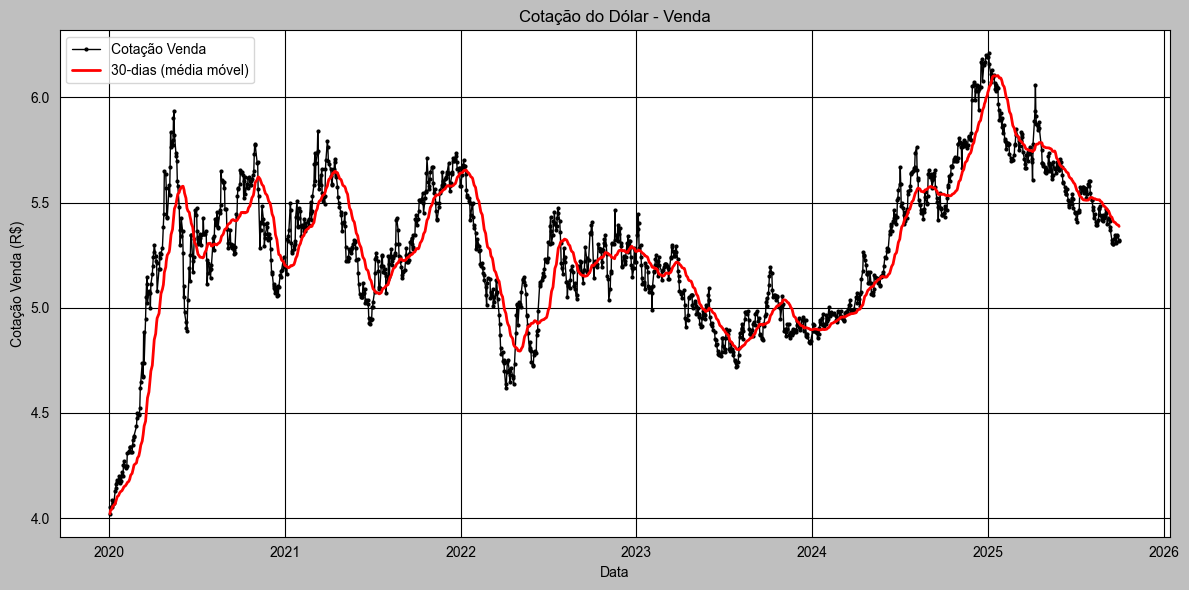

In [25]:
# Plot da cotação de venda ao longo do tempo
# Gera gráfico da série temporal, adiciona média móvel opcional e salva a figura.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')


# Configurações: janela para média móvel (em dias). Defina None para desativar.
rolling_window = 30

if 'dataHoraCotacao' in df_cotacoes.columns and 'cotacaoVenda' in df_cotacoes.columns:
    # Prepara dados ordenados por data
    df_plot = df_cotacoes.sort_values('dataHoraCotacao').copy()
    df_plot = df_plot.dropna(subset=['dataHoraCotacao','cotacaoVenda'])

    # Converte índice para facilitar plot (mantemos coluna também)
    df_plot.set_index('dataHoraCotacao', inplace=True)

    plt.style.use('grayscale')
    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(df_plot.index, df_plot['cotacaoVenda'], marker='.', markersize=4, linewidth=1, label='Cotação Venda')

    if rolling_window is not None and rolling_window > 1:
        rol = df_plot['cotacaoVenda'].rolling(window=rolling_window, min_periods=1).mean()
        ax.plot(df_plot.index, rol, color='red', linewidth=2, label=f'{rolling_window}-dias (média móvel)')

    # Formata eixo x para datas
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    ax.set_xlabel('Data')
    ax.set_ylabel('Cotação Venda (R$)')
    ax.set_title('Cotação do Dólar - Venda')
    ax.legend()
    fig.tight_layout()

    # Salva figura
    out_path = 'cotacao_dolar_plot.png'
    fig.savefig(out_path, dpi=150)
    print(f"Gráfico gerado e salvo em: {out_path}")
    plt.show()
else:
    print("As colunas necessárias não foram encontradas no DataFrame. Verifique se a célula que cria `df_cotacoes` foi executada.")